In [1]:
import torch
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F


In [2]:
imagens = []
labels = []

for class_folder in range(1,6):
    folder_path = f"tlinter/classe{class_folder}"
    
    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file_name)
        
        image = cv2.imread(image_path)
        
        imagens.append(image)
        labels.append(int(class_folder))


In [3]:
x_train, x_test, y_train, y_test = train_test_split(imagens, labels, test_size=0.2, random_state=42)

In [4]:
data_dir = "to_torch/train/"
test_data_dir = "to_torch/test/"

dataset = ImageFolder(data_dir, transform= transforms.Compose([
    transforms.Resize((150,150)), transforms.ToTensor()
]))

test_dataset  = ImageFolder(test_data_dir, transform= transforms.Compose([
    transforms.Resize((150,150)), transforms.ToTensor()
]))

In [5]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 150, 150]) 0


In [6]:
print("Classes de treino : \n",dataset.classes)
print("Classes de teste : \n",test_dataset.classes)

Classes de treino : 
 ['classe1', 'classe2', 'classe3', 'classe4', 'classe5']
Classes de teste : 
 ['classe1', 'classe2', 'classe3', 'classe4', 'classe5']


Label: classe1


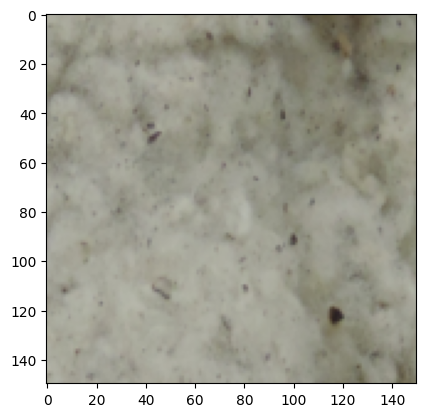

In [7]:
def display_img(img,label):
    print(f"Label: {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))
    
display_img(*dataset[1])

In [8]:
batch_size = 5
val_size = 20
train_size = len(dataset) - val_size

#randomizando o grupo de treinamento e testes
train_data, val_data = random_split(dataset,[train_size, val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 80
Length of Validation Data : 20


In [9]:
#carregando o treino e validação nos batches
train_dl = DataLoader(train_data, batch_size, shuffle= True, num_workers=4, pin_memory= True)
val_dl = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory= True)

In [10]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # gerando predições
        loss = F.cross_entropy(out, labels) # calculo de loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # gerando prediçoes
        loss = F.cross_entropy(out, labels)   # calculando loss
        acc = accuracy(out, labels)           # caculando acuracia
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   #  combinando loss
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # combinando acuracias
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:
class CottonClassClassification(ImageClassificationBase):
    
    def __init__(self):
        
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,6)
        )
    
    def forward(self, xb):
        return self.network(xb)
    

In [15]:
model = CottonClassClassification()
model

CottonClassClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=82944, out_features=1024, bias=True)
    (17): ReLU()
    (18): Lin

In [17]:
for images, labels in train_dl:
    print("image.shape", image.shape)
    out = model(images)
    print("out.shape", out.shape)
    print("out[0]", out[0])
    break

image.shape (780, 1000, 3)
out.shape torch.Size([5, 6])
out[0] tensor([ 0.0180, -0.0359,  0.0355,  0.0376, -0.0153,  0.0382],
       grad_fn=<SelectBackward0>)


## TREINANDO O MODELO

In [21]:
# TREINANDO o moderlo
  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [20]:
model.parameters()

<generator object Module.parameters at 0x7fe6d10cc3c0>

In [28]:
num_epochs = 30
opt_func = torch.optim.SGD()
lr = 0.001
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.6341, val_loss: 1.7533, val_acc: 0.0500
Epoch [1], train_loss: 1.6304, val_loss: 1.7389, val_acc: 0.0500
Epoch [2], train_loss: 1.6274, val_loss: 1.7317, val_acc: 0.0500
Epoch [3], train_loss: 1.6255, val_loss: 1.7238, val_acc: 0.0500
Epoch [4], train_loss: 1.6229, val_loss: 1.7186, val_acc: 0.0500
Epoch [5], train_loss: 1.6219, val_loss: 1.7100, val_acc: 0.0500
Epoch [6], train_loss: 1.6179, val_loss: 1.7028, val_acc: 0.0500
Epoch [7], train_loss: 1.6177, val_loss: 1.7000, val_acc: 0.0500
Epoch [8], train_loss: 1.6167, val_loss: 1.6944, val_acc: 0.0500
Epoch [9], train_loss: 1.6149, val_loss: 1.6910, val_acc: 0.0500
Epoch [10], train_loss: 1.6151, val_loss: 1.6894, val_acc: 0.0500
Epoch [11], train_loss: 1.6148, val_loss: 1.6872, val_acc: 0.0500
Epoch [12], train_loss: 1.6156, val_loss: 1.6812, val_acc: 0.0500
Epoch [13], train_loss: 1.6135, val_loss: 1.6814, val_acc: 0.0500
Epoch [14], train_loss: 1.6132, val_loss: 1.6784, val_acc: 0.0500
Epoch [15], train_lo

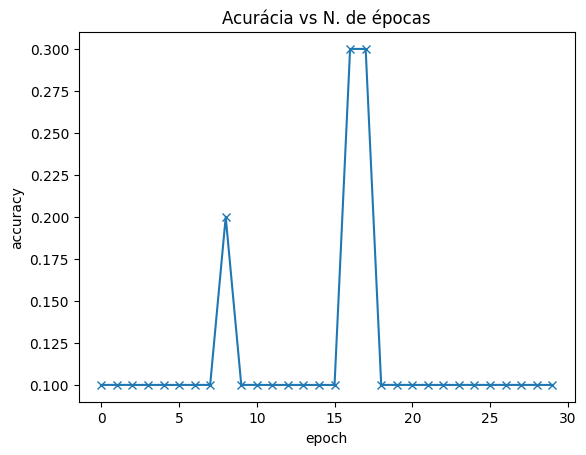

In [101]:
def plot_accuracies(history):
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Acurácia vs N. de épocas")
    
plot_accuracies(history)

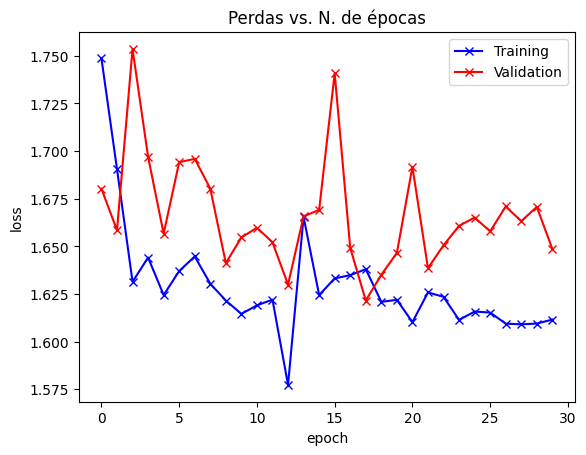

In [102]:
def plot_losses(history):
    
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Perdas vs. N. de épocas');

plot_losses(history)        